# Stellar Population Generator
by Claudia Álvarez-Rojas and Giorgos Galanaquis Giovagnoli

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Functions

In [2]:
def imf_kroupa(m):
    """
    Calculation of the Initial Mass Function (IMF) value following the 
    Kroupa (2001) piecewise form.

    input:
    -------
    m  (float or np.array):
        stellar mass in Solar masses.

    return:
    -------
    y  (float or np.array):
        proportional value of the IMF at mass m.
    """
    denom = 0.08**(-1.3)
    if m >= 0.08 and m < 0.5:
        y = ((m**(-1.3)))/denom
    elif m >= 0.5 and m < 1.0:
        y = ((m**(-2.3))*0.5)/denom
    elif m >= 1.0 and m < 100.0:
        y = ((m**(-2.3))*0.5)/denom
    else:
        y = 0 
    return y

In [3]:
def initial_mass_generation(quantity=1e6, lowest_mass=0.08, highest_mass=100.0, seed=None):
    """
    Generate an array of initial stellar masses using rejection sampling
    based on the Kroupa IMF.
    
    This function performs a Monte Carlo sampling procedure in which
    candidate stellar masses are drawn from a uniform distribution and 
    accepted or rejected probabilistically according to the value of the 
    Kroupa IMF at each mass. The resulting distribution of accepted masses 
    statistically reproduces the desired IMF.

    input
    ----------
    quantity : int or float, optional
        number of candidate masses to generate before rejection sampling.
        Default is 1e6.
    lowest_mass : float, optional
        minimum stellar mass allowed (in solar masses). Default is 0.08.
    highest_mass : float, optional
        maximum stellar mass allowed (in solar masses). Default is 100.0.
    seed : int or None, optional
        random seed for reproducibility. Default is None.

    return
    -------
    accepted_m : numpy.ndarray
        array of stellar masses that pass the Kroupa IMF rejection test.
    """

    quantity = int(quantity)
    
    rng = np.random.default_rng(seed)

    random_m = rng.uniform(lowest_mass, high=highest_mass, size=quantity)
    random_m.sort()
    data = [imf_kroupa(m) for m in random_m]

    random_p = rng.uniform(0., high=1., size=quantity)

    accepted_m = []
    
    for i in range(quantity):
        if data[i] > random_p[i]:
            accepted_m.append(random_m[i])
    accepted_m = np.array(accepted_m)

    return accepted_m

In [4]:
def evolution_time(accepted_m, t_tot=1e10, seed=None):
    """
    Generate random birth times and corresponding evolution times 
    for a population of stars.

    Each star is assigned a random formation time between 0 and t_tot.
    The evolution time is then computed as the remaining time until t_tot.

    input
    ----------
    accepted_m : array-like
        array of stellar masses previously accepted from the IMF sampling.
        Only the length of this array is used.
    t_tot : float, optional
        total simulation time (in years). Default is 1e10, corresponding to 
        the approximate lifetime of the Milky Way.
    seed : int or None, optional
        random seed for reproducibility. Default is None.

    return
    -------
    ran_t0 : numpy.ndarray
        array of random birth times for each star.
    t_evo : numpy.ndarray
        evolution times, computed as t_tot - ran_t0.
    """

    rng = np.random.default_rng(seed)
    
    ran_t0 = rng.uniform(0,t_tot,len(accepted_m))

    t_evo = t_tot - ran_t0

    ran_t0 = np.array(ran_t0)
    t_evo = np.array(t_evo)
    
    return ran_t0,t_evo

In [5]:
def life_value(m,t_evo,t_tot):
    """
    Evaluate wheter a star remains on the Main Sequence or has already
    ended its life.
    
    input:
    -------
    m      (float or np.array):
           stellar mass in Solar masses
    t_evo  (float or np.array):
           elapsed evolution time of the star (in years)
    t_tot  (float):
           total available time (in years) (e.g., age of Milky Way)

    return:
    -------
    survival : bool or numpy.ndarray of bool
        True  --> the star is still on the Main Sequence  
        False --> the star has died and evolved into a compact remnant
    t_life : float or numpy.ndarray
        lifetime of each star (in years) based on the mass-lifetime relation t proportional to  m^(-2.5).
    t_dead : float or numpy.ndarray
        time (in years) elapsed since the star's death. Zero for stars still alive.
    
    Notes
    -----
    The stellar lifetime is approximated as:

        t_life = t_tot / (m ** 2.5)

    A star is considered alive (Main Sequence) if:

        t_evo < t_life

    Otherwise, its time since death is:

        t_dead = max(t_evo - t_life, 0)
    """
    m = np.asarray(m, float)
    t_evo = np.asarray(t_evo, float)
    
    t_life = t_tot/(m**2.5) 
    survival = t_evo < t_life

    t_dead_all = t_evo-t_life
    t_dead = np.where(t_dead_all > 0, t_dead_all, 0.0)
    
    return survival,t_life,t_dead

In [6]:
def WD_mass(M):
    """
    Compute the final mass of a White Dwarf (WD) for progenitors
    with initial masses between 0.08 and 8 solar masses.
    The white dwarf mass prescription implemented here follows the
    empirical IFMR of Kalirai et al. (2008).

    input
    ----------
    M : float or array-like
        initial stellar mass in solar masses.

    return
    -------
    Mf : numpy.ndarray
        white dwarf final mass. Values outside the valid mass range are NaN.
    """
    M = np.asarray(M, dtype=float)
    Mf = np.full_like(M, np.nan)
    mask = (M >= 0.08) & (M < 8)
    Mf[mask] = 0.109*M[mask] + 0.394
    return Mf

def WD_mass_upperpolated(M):
    """
    Compute an upper-extrapolated WD mass in the transition region
    between 8 and 9 solar masses.

    input
    ----------
    M : float or array-like
        initial stellar mass.

    return
    -------
    Mf : numpy.ndarray
        interpolated WD mass for 8 ≤ M < 9. NaN elsewhere.
    """
    M = np.asarray(M, dtype=float)
    Mf = np.full_like(M, np.nan)
    mask = (M >= 8) & (M < 9)
    Mf[mask] = 0.109*M[mask] + 0.394 #+ 1.266
    return Mf

def NS_mass_downpolated(M):
    """
    Compute a down-extrapolated neutron star (NS) mass for progenitors
    between 8 and 9 solar masses.

    input
    ----------
    M : float or array-like
        initial stellar mass.

    return
    -------
    Mf : numpy.ndarray
        down-polulated NS mass. NaN outside 8 ≤ M < 9.
    """
    M = np.asarray(M, dtype=float)
    Mf = np.full_like(M, np.nan)
    mask1 = (M >= 8) & (M < 9)
    x = M[mask1] - 14.75
    Mf[mask1] = 2.24 + 0.508*x + 0.125*x**2 + 0.0110*x**3
    return Mf

def NS_mass(M):
    """
    Compute the final neutron star mass for a range of stellar
    progenitor masses from 9 to 18.5 solar masses. Multiple
    piecewise relations are applied in different mass intervals.
    The prescription implemented here follows the remnant mass models of 
    Raithel et al. (2018).

    input
    ----------
    M : float or array-like
        initial mass in solar masses.

    return
    -------
    Mf : numpy.ndarray
        neutron star masses. Values outside 9 ≤ M < 18.5 are NaN.
    """
    M = np.asarray(M, dtype=float)
    Mf = np.full_like(M, np.nan)
    mask1 = (M >= 9) & (M < 13)
    x = M[mask1] - 14.75
    Mf[mask1] = 2.24 + 0.508*x + 0.125*x**2 + 0.0110*x**3
    mask2 = (M >= 13) & (M < 15)
    Mf[mask2] = 0.123 + 0.112*M[mask2]
    mask3 = (M >= 15) & (M < 17.8)
    Mf[mask3] = 0.996 + 0.0384*M[mask3]
    mask4 = (M >= 17.8) & (M < 18.5)
    Mf[mask4] = -0.020 + 0.10*M[mask4]
    return Mf

def NS_mass_upperpolated(M):
    """
    Compute an upper-extrapolated NS mass for progenitors between
    15 and 18.5 solar masses, applying the appropriate
    piecewise mass relations.

    input
    ----------
    M : float or array-like
        initial mass.

    return
    -------
    Mf : numpy.ndarray
        upper-extrapolated NS masses. NaN outside 15 ≤ M < 18.5.
    """
    M = np.asarray(M, dtype=float)
    Mf = np.full_like(M, np.nan)
    mask3 = (M >= 15) & (M < 17.8)
    Mf[mask3] = 0.996 + 0.0384*M[mask3]
    mask4 = (M >= 17.8) & (M < 18.5)
    Mf[mask4] = -0.020 + 0.10*M[mask4]
    return Mf

def BH_mass_downpolated(M):
    """
    Compute a down-extrapolated black hole (BH) mass for progenitors
    between 15 and 18.5 solar masses. Uses a combination of
    core-mass and fallback formulas.
    The prescription implemented here follows the remnant mass models of 
    Raithel et al. (2018).

    input
    ----------
    M : float or array-like
        initial stellar mass.

    return
    -------
    Mf : numpy.ndarray
        down-extrapolated BH mass. NaN outside 15 ≤ M < 18.5.
    """
    M = np.asarray(M, dtype=float)
    Mf = np.full_like(M, np.nan)

    f_ej = 0.9

    mask_I = (M >= 15) & (M < 18.5)

    M_core = -2.049 + 0.4140*M
    x = M - 25.97
    M_all  = 15.52 - 0.3294*x - 0.02121*x*2 + 0.003120*x**3

    Mf[mask_I] = f_ej*M_core[mask_I] + (1-f_ej)*M_all[mask_I]

    return Mf

def BH_mass(M):
    """
    Compute the final black hole mass for progenitors between 
    18.5 and 120 solar masses. Includes fallback-dominated,
    pair-instability gap, and high-mass prescriptions.

    input
    ----------
    M : float or array-like
        initial stellar mass.

    return
    -------
    Mf : numpy.ndarray
        black hole final mass. Values outside 18.5 ≤ M < 120 are NaN.
    """
    M = np.asarray(M, dtype=float)
    Mf = np.full_like(M, np.nan)

    f_ej = 0.9

    mask_I = (M >= 18.5) & (M < 40)

    M_core = -2.049 + 0.4140*M
    x = M - 25.97
    M_all  = 15.52 - 0.3294*x - 0.02121*x*2 + 0.003120*x**3

    Mf[mask_I] = f_ej*M_core[mask_I] + (1-f_ej)*M_all[mask_I]
    mask_II = (M >= 45) & (M < 120)
    Mf[mask_II] = 5.697 + 7.8598e8 * (M[mask_II]**-4.858)

    mask_gap = (M >= 40) & (M < 45)
    if np.any(mask_gap):
        M40 = 14.95188002
        M45 = 5.697 + 7.8598e8 * (45**-4.858)
        Mf[mask_gap] = M40 + (M[mask_gap]-40)*(M45-M40)/5

    return Mf

def WDNS_mass(M,seed=None):
    """
    Randomly assign an 8–9 solar mass progenitor to produce either a
    white dwarf or a neutron star, and compute its final mass
    accordingly.

    input
    ----------
    M : array-like
        initial stellar masses.
    seed : int or None, optional
        random seed for reproducibility.

    return
    -------
    final_mass : numpy.ndarray
        final mass, choosing WD or NS upper/lower extrapolated relations randomly.
    ran_destiny : numpy.ndarray of str
        array of "WD" or "NS" indicating the randomly uniform chosen remnant type.
    """
    rng = np.random.default_rng(seed)
    mask = (M >= 8) & (M < 9)
    ran_destiny = rng.choice(["WD", "NS"], size=len(M))
    return (np.where(ran_destiny == "WD", WD_mass_upperpolated(M), NS_mass_downpolated(M)),ran_destiny)

def NSBH_mass(M,seed=None):
    """
    Randomly assign a 15–18.5 solar mass progenitor to become either a
    neutron star or a black hole, and compute the final mass using the
    appropriate prescription.

    input
    ----------
    M : array-like
        initial stellar masses.
    seed : int or None, optional
        random seed for reproducibility.

    return
    -------
    final_mass : numpy.ndarray
        final mass using NS or BH upper/lower extrapolated relations randomly.
    ran_destiny : numpy.ndarray of str
        array of "NS" or "BH" indicating the randomly uniform chosen remnant type.
    """
    rng = np.random.default_rng(seed)
    mask = (M >= 15) & (M < 18.5)
    ran_destiny = rng.choice(["NS", "BH"], size=len(M))
    return (np.where(ran_destiny == "NS", NS_mass_upperpolated(M), BH_mass_downpolated(M)),ran_destiny)

In [7]:
def get_final_mass(Mi,seed=None):
    """
    Compute the final mass and remnant type produced by stars of initial mass Mi
    according to the implemented IFMR (WD, NS, BH).

    input:
    -------
    Mi  (float or np.array):
        initial stellar mass in Solar masses
    seed : int or None, optional
        random seed for stochastic transitions (WD↔NS and NS↔BH regions).

    return:
    -------
    Mf : numpy.ndarray
        final mass of the stellar remnant. Values correspond to WD, NS, or BH
        prescriptions depending on the progenitor mass.
    remnant : numpy.ndarray of str
        remnant type for each initial mass. One of:
            "WD"  -->  White Dwarf  
            "NS"  -->  Neutron Star  
            "BH"  -->  Black Hole  
            "MS"  -->  For masses not reaching remnant stage (not expected here)

    Notes
    -----
    Mass intervals follow the implemented prescriptions:
        Mi < 8           --> WD  
        8 ≤ Mi < 9       --> Randomly WD or NS  
        9 ≤ Mi < 15      --> NS  
        15 ≤ Mi < 18.5   --> Randomly NS or BH  
        Mi ≥ 18.5        --> BH
    """
    Mi = np.array(Mi)
    Mf = np.zeros_like(Mi)
    remnant = np.zeros_like(Mi)
    fill_string = "MS"
    remnant = np.full(np.shape(Mi), fill_value=fill_string)

    # WD
    mask_WD = Mi < 8
    Mf[mask_WD] = WD_mass(Mi[mask_WD])
    remnant[mask_WD] = "WD"

    # WD/NS
    mask_WDNS = (Mi >= 8) & (Mi < 9)
    Mf[mask_WDNS],remnant[mask_WDNS] = WDNS_mass(Mi[mask_WDNS],seed)
    
    # NS
    mask_NS = (Mi >= 9) & (Mi < 15)
    Mf[mask_NS] = NS_mass(Mi[mask_NS])
    remnant[mask_NS] = "NS"
    
    # NS/BH
    mask_NSBH = (Mi >= 15) & (Mi < 18.5)
    Mf[mask_NSBH],remnant[mask_NSBH] = NSBH_mass(Mi[mask_NSBH],seed)
    
    # BH
    mask_BH = Mi >= 18.5
    Mf[mask_BH] = BH_mass(Mi[mask_BH])
    remnant[mask_BH] = "BH"
    
    return Mf,remnant

In [8]:
def main_mass(m,t_evo,t_tot=1e10,seed=None):
    """
    Determine the current mass and evolutionary state of stars given their 
    initial mass and evolution time. Stars still alive (Main Sequence) retain 
    their initial mass, while stars that have died receive a remnant mass 
    computed from the IFMR prescriptions (WD, NS, BH).

    input
    ----------
    m : float or array-like
        initial stellar mass in solar masses.
    t_evo : float or array-like
        time (in years) elapsed since birth for each star.
    t_tot : float, optional
        total reference timescale for defining stellar lifetimes (in years).
        default is 1e10 years (approximate age of the Milky Way).
    seed : int or None, optional
        random seed for stochastic transitions in the IFMR (WD↔NS, NS↔BH).

    return
    -------
    Mf : numpy.ndarray
        current mass of the star:
            - Stars still on the Main Sequence --> Mf = Mi
            - Stars that have died             --> remnant mass (WD/NS/BH)
    remnant : numpy.ndarray of str
        evolutionary state of each star:
            "MS" --> Main Sequence (still alive)
            "WD" --> White Dwarf
            "NS" --> Neutron Star
            "BH" --> Black Hole

    Notes
    -----
    The function uses:
        - `life_value()` to determine whether the star is alive.
        - `get_final_mass()` to assign final remnant masses to dead stars.
    """
    Mi = np.array(m)
    Mf = np.zeros_like(Mi)
    remnant = np.zeros_like(Mi)
    fill_string = "MS"
    remnant = np.full(np.shape(Mi), fill_value=fill_string)

    survival_mask = life_value(m,t_evo,t_tot)[0] # Survival Mask

    Mf[survival_mask] = Mi[survival_mask]
    remnant[survival_mask] = "MS"

    Mf[~survival_mask],remnant[~survival_mask] = get_final_mass(Mi[~survival_mask],seed)
    
    return Mf,remnant

In [9]:
def main(quantity_MC=1e6, lowest_mass=0.08, highest_mass=100, t_tot=1e10, seed=None):
    """
    Run a full Monte Carlo stellar population simulation. Generate initial masses,
    assign birth times, compute lifetimes and evolutionary stages, and return a
    complete DataFrame describing each simulated star.

    input
    ----------
    quantity_MC : int or float, optional
        number of initial Monte Carlo mass samples to draw from the IMF.
        default is 1e6.
    lowest_mass : float, optional
        minimum stellar mass to generate. Default is 0.08 solar masses.
    highest_mass : float, optional
        maximum stellar mass to generate. Default is 100 solar masses.
    t_tot : float, optional
        total time span of the simulation (in years). Default is 1e10, the 
        approximate age of the Milky Way.
    seed : int or None, optional
        random seed for reproducibility.

    return
    -------
    stars_df : pandas.DataFrame
        dataFrame with one row per star containing:
            Mi          -->  initial mass
            Mf          -->  final / current mass
            type        -->  MS, WD, NS, or BH
            life_value  -->  True if alive, False if dead
            t_birth     -->  random formation time
            t_evo       -->  elapsed evolution time
            t_life      -->  theoretical lifetime
            t_dead      -->  time since stellar death (0 if alive)

    Notes
    -----
    This function performs the full stellar evolution pipeline:
        1. Masses from `initial_mass_generation()`
        2. Birth and evolution times from `evolution_time()`
        3. Lifetimes from `life_value()`
        4. Current/remnant mass + type from `main_mass()`
    """
    Mi = initial_mass_generation(quantity_MC,lowest_mass,highest_mass,seed)
    
    ran_t0,t_evo, = evolution_time(Mi,t_tot,seed)
    alive,t_life,t_dead = life_value(Mi,t_evo,t_tot)
    
    Mf,remnant = main_mass(Mi,t_evo)

    stars_df = pd.DataFrame({
    "Mi": Mi,
    "Mf": Mf,
    "type": remnant,
    "life_value": alive,
    "t_birth": ran_t0,
    "t_evo": t_evo,
    "t_life": t_life,
    "t_dead": t_dead
    })
    
    return stars_df

# Main

In [10]:
df = main(quantity_MC=2e7, lowest_mass=0.08, highest_mass=100, t_tot=1e10, seed=67)

In [11]:
df.columns

Index(['Mi', 'Mf', 'type', 'life_value', 't_birth', 't_evo', 't_life',
       't_dead'],
      dtype='object')

# Plots
Some graphs to visualize the Simulated Stellar Population.

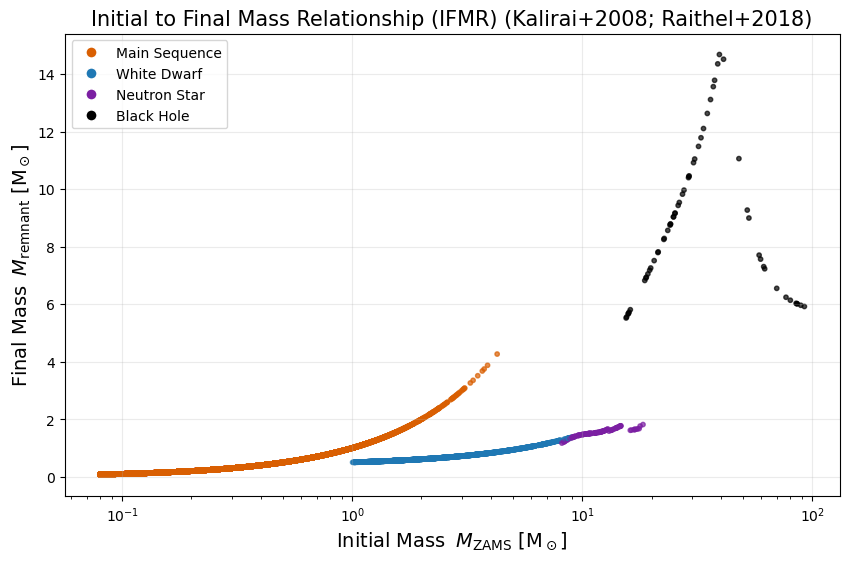

In [12]:
%matplotlib inline

Mi = df["Mi"]
Mf = df["Mf"]
remnants = df["type"]

colors = np.where(remnants=="MS", "#d95f02", np.where(remnants=="WD", "#1f78b4", np.where(remnants=="NS", "#7b1fa2", "#000000")))


plt.figure(figsize=(10,6))

plt.scatter(Mi, Mf, c=colors, s=10, alpha=0.7)

plt.xlabel("Initial Mass $\: M_{\\rm ZAMS}$ [M$_\\odot$]", fontsize=14)
plt.ylabel("Final Mass $\: M_{\\rm remnant}$ [M$_\\odot$]", fontsize=14)
plt.title("Initial to Final Mass Relationship (IFMR) (Kalirai+2008; Raithel+2018)", fontsize=15)

plt.grid(alpha=0.25)


from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Main Sequence', markerfacecolor='#d95f02', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='White Dwarf', markerfacecolor='#1f78b4', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Neutron Star', markerfacecolor='#7b1fa2', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Black Hole',  markerfacecolor='#000000', markersize=8),
]
plt.legend(handles=legend_elements)

plt.xscale('log')  # Set x-axis to logarithmic scale
#plt.yscale('log') 
#plt.ylim(0, 100)
#plt.xlim(0, 100)

plt.savefig("ifmr_claudia_giorgos.png")
plt.show()

To visualize the fraction of each object:

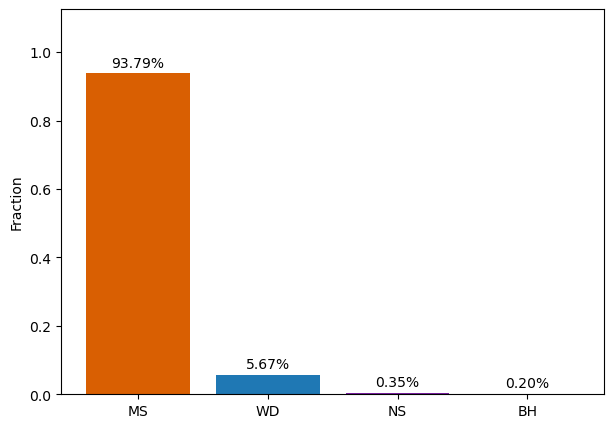

      Type    |   Count  |   Fraction
--------------|-------------|-------------------
MS            | 27827       |  93.79%
WD            | 1681        |   5.67%
NS            | 104         |   0.35%
BH            | 59          |   0.20%


In [13]:
%matplotlib inline

labels = ['MS', 'WD', 'NS', 'BH']
remnant = df['type'].values
counts = np.array([np.sum(remnant == x) for x in labels])
frac = counts / len(remnant)

plt.figure(figsize=(7,5))
bars = plt.bar(labels, frac, color=['#d95f02','#1f78b4','#7b1fa2','#000000'])
plt.ylabel('Fraction')
#plt.title('Fracción de tipos estelares (Monte Carlo 10 Gyr)')
plt.ylim(0, max(frac)*1.20)


for bar, f in zip(bars, frac):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 0.01,
             f"{100*f:.2f}%",
             ha='center', va='bottom', fontsize=10)
    
plt.savefig("remnant_proportion_claudia_giorgos.png")
plt.show()


print("      Type    |   Count  |   Fraction")
print("--------------|-------------|-------------------")
for lab, c, f in zip(labels, counts, frac):
    print(f"{lab:<14}| {c:<11} | {100*f:6.2f}%")


To visualize the type of object that results from each initial mass and evolution time:

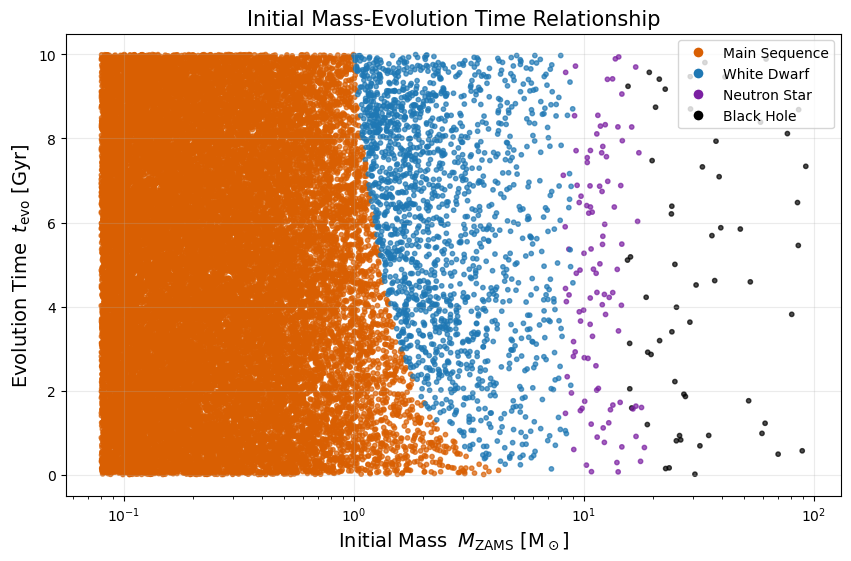

In [14]:
%matplotlib inline

Mi = df["Mi"]
t_evo = df["t_evo"]
remnants = df["type"]

colors = np.where(remnants=="MS", "#d95f02", np.where(remnants=="WD", "#1f78b4", np.where(remnants=="NS", "#7b1fa2", "#000000")))


plt.figure(figsize=(10,6))

plt.scatter(Mi, t_evo*1e-9, c=colors, s=10, alpha=0.7)

plt.xlabel("Initial Mass $\: M_{\\rm ZAMS}$ [M$_\\odot$]", fontsize=14)
plt.ylabel("Evolution Time $\: t_{\\rm evo}$ [Gyr]", fontsize=14)
plt.title("Initial Mass-Evolution Time Relationship", fontsize=15)

plt.grid(alpha=0.25)


from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Main Sequence', markerfacecolor='#d95f02', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='White Dwarf', markerfacecolor='#1f78b4', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Neutron Star', markerfacecolor='#7b1fa2', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Black Hole',  markerfacecolor='#000000', markersize=8),
]
plt.legend(handles=legend_elements)
plt.xscale('log')  # Set x-axis to logarithmic scale
#plt.yscale('log') 
#plt.ylim(0, 1e10)
#plt.xlim(0, 100)

plt.savefig("mi_tevo_claudia_giorgos.png")
plt.show()

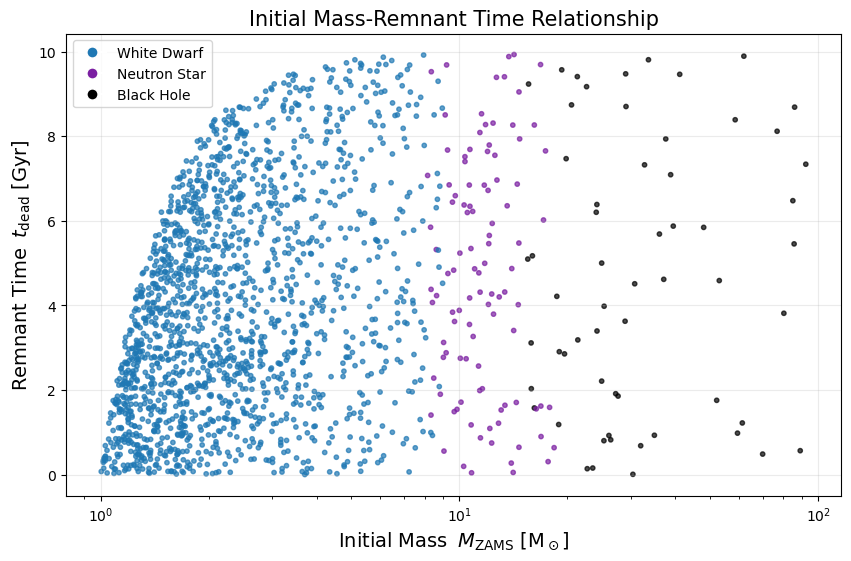

In [15]:
%matplotlib inline
mask = df["type"].isin(["WD", "NS", "BH"])
Mi      = df.loc[mask, "Mi"]
t_dead  = df.loc[mask, "t_dead"]
remnants = df.loc[mask, "type"]

colors = np.where(remnants=="WD", "#1f78b4",
         np.where(remnants=="NS", "#7b1fa2",
                  "#000000"))  # BH

plt.figure(figsize=(10,6))

plt.scatter(Mi, t_dead*1e-9, c=colors, s=10, alpha=0.7)

plt.xlabel("Initial Mass $\: M_{\\rm ZAMS}$ [M$_\\odot$]", fontsize=14)
plt.ylabel("Remnant Time $\: t_{\\rm dead}$ [Gyr]", fontsize=14)
plt.title("Initial Mass-Remnant Time Relationship", fontsize=15)
plt.grid(alpha=0.25)

legend_elements = [
    Line2D([], [], marker='o', color='w', label='White Dwarf',  markerfacecolor='#1f78b4', markersize=8),
    Line2D([], [], marker='o', color='w', label='Neutron Star', markerfacecolor='#7b1fa2', markersize=8),
    Line2D([], [], marker='o', color='w', label='Black Hole',   markerfacecolor='#000000', markersize=8),
]
plt.legend(handles=legend_elements)

plt.xscale('log')
# plt.yscale('log')

plt.savefig("mi_tdead_claudia_giorgos.png")
plt.show()


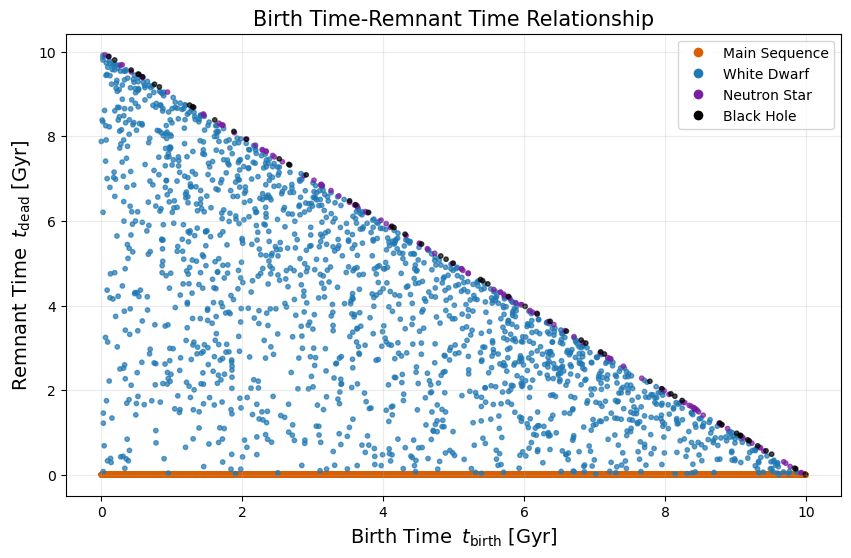

In [16]:
%matplotlib inline

t_birth = df["t_birth"]
t_dead = df["t_dead"]
remnants = df["type"]

colors = np.where(remnants=="MS", "#d95f02", np.where(remnants=="WD", "#1f78b4", np.where(remnants=="NS", "#7b1fa2", "#000000")))


plt.figure(figsize=(10,6))

plt.scatter(t_birth*1e-9, t_dead*1e-9, c=colors, s=10, alpha=0.7)

plt.xlabel("Birth Time $\: t_{\\rm birth}$ [Gyr]", fontsize=14)
plt.ylabel("Remnant Time $\: t_{\\rm dead}$ [Gyr]", fontsize=14)
plt.title("Birth Time-Remnant Time Relationship", fontsize=15)

plt.grid(alpha=0.25)


from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Main Sequence', markerfacecolor='#d95f02', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='White Dwarf', markerfacecolor='#1f78b4', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Neutron Star', markerfacecolor='#7b1fa2', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Black Hole',  markerfacecolor='#000000', markersize=8),
]
plt.legend(handles=legend_elements)
#plt.xscale('log')  # Set x-axis to logarithmic scale
#plt.yscale('log') 
#plt.ylim(0, 1e10)
#plt.xlim(0, 100)

plt.savefig("tbirth_tdead_claudia_giorgos.png")
plt.show()

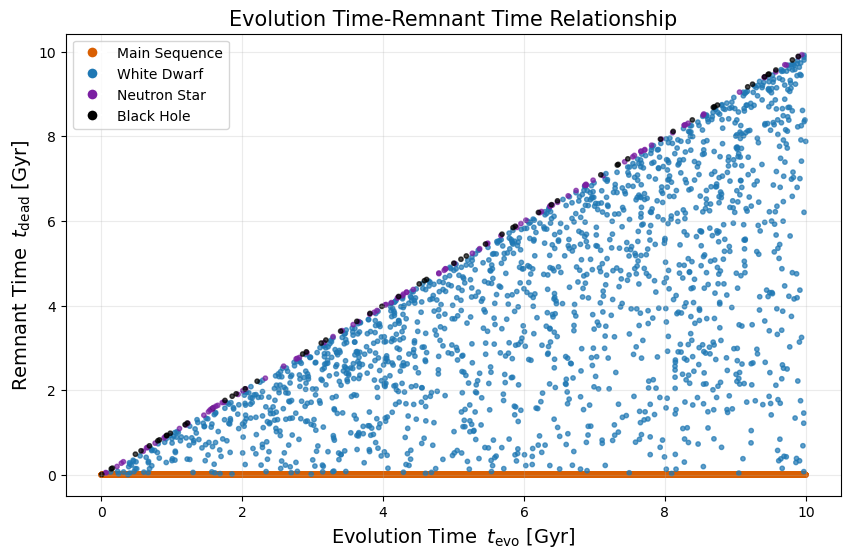

In [17]:
%matplotlib inline

t_evo = df["t_evo"]
t_dead = df["t_dead"]
remnants = df["type"]

colors = np.where(remnants=="MS", "#d95f02", np.where(remnants=="WD", "#1f78b4", np.where(remnants=="NS", "#7b1fa2", "#000000")))


plt.figure(figsize=(10,6))

plt.scatter(t_evo*1e-9, t_dead*1e-9, c=colors, s=10, alpha=0.7)

plt.xlabel("Evolution Time $\: t_{\\rm evo}$ [Gyr]", fontsize=14)
plt.ylabel("Remnant Time $\: t_{\\rm dead}$ [Gyr]", fontsize=14)
plt.title("Evolution Time-Remnant Time Relationship", fontsize=15)

plt.grid(alpha=0.25)


from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Main Sequence', markerfacecolor='#d95f02', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='White Dwarf', markerfacecolor='#1f78b4', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Neutron Star', markerfacecolor='#7b1fa2', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Black Hole',  markerfacecolor='#000000', markersize=8),
]
plt.legend(handles=legend_elements)
#plt.xscale('log')  # Set x-axis to logarithmic scale
#plt.yscale('log') 
#plt.ylim(0, 1e10)
#plt.xlim(0, 100)

plt.savefig("tevo_tdead_claudia_giorgos.png")
plt.show()